In [139]:
from huggingface_hub import TextToAudioOutput
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split

n_x = 50000
# Determine p
p = np.logspace(-5, -2, n_x)

# Set covariates x
input_size = 20
x = stats.norm.rvs(loc=p.reshape(-1,1), scale=p.reshape(-1,1)/50., size=(n_x, input_size))
x /= x.mean()
n_x, input_size = x.shape

# Instead of a fixed n_samples, sample a random number of samples for each observation.
# For instance, drawing from a Uniform distribution between 1 and 20000
n_samples_budget = 50 * n_x
n_samples_uniform = np.ones(n_x, dtype=int) * (n_samples_budget // n_x)

# Generate y for each observation using a list comprehension.
# Each element in y will be an array of Bernoulli trials with its own sample size.
y_uniform = [np.random.binomial(1, prob, n) for prob, n in zip(p, n_samples_uniform)]

# Sum the outcomes for each observation.
b_uniform = np.array([yi.sum() for yi in y_uniform])

# For example, if you want to compute the "first success" (t_tilde) for each observation:
# Note: since each array in y may have a different length, you need to loop through them.
t_tilde_uniform = np.array([np.argmax(yi) + 1 if yi.any() else len(yi) for yi in y_uniform])

# And you can construct an event indicator (e) similarly:
# Here, e indicates whether a success occurred.
e_uniform = np.array([1 if yi.any() else 0 for yi in y_uniform])

print("Example of first 10 p values:", p[:10])
print("Example of corresponding empirical probabilities:", b_uniform[:10] / n_samples_uniform[:10])

# Make a train-test split
p_train, p_test, x_train, x_test, y_uniform_train, y_uniform_test, t_tilde_uniform_train, t_tilde_uniform_test, e_uniform_train, e_uniform_test, b_uniform_train, b_uniform_test, n_samples_uniform_train, n_samples_uniform_test = train_test_split(
    p, x, y_uniform, t_tilde_uniform, e_uniform, b_uniform, n_samples_uniform, test_size=0.2, random_state=42)

# Split a calibration set from the training set
p_train, p_cal, x_train, x_cal, y_uniform_train, y_uniform_cal, t_tilde_uniform_train, t_tilde_uniform_cal, e_uniform_train, e_uniform_cal, b_uniform_train, b_uniform_cal, n_samples_uniform_train, n_samples_uniform_cal = train_test_split(
    p_train, x_train, y_uniform_train, t_tilde_uniform_train, e_uniform_train, b_uniform_train, n_samples_uniform_train, test_size=0.25, random_state=42)

Example of first 10 p values: [1.00000000e-05 1.00013817e-05 1.00027635e-05 1.00041456e-05
 1.00055278e-05 1.00069103e-05 1.00082929e-05 1.00096757e-05
 1.00110587e-05 1.00124419e-05]
Example of corresponding empirical probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [140]:
def allocate_coins(probabilities, m, tol=1e-6):
    """
    Allocate m trials among experiments with given success probabilities
    using the continuous relaxation approach.
    
    Parameters:
      probabilities: list of p_i values (each in (0,1))
      m: total number of trials to allocate
      tol: tolerance for the bisection convergence
    
    Returns:
      allocation: list of trial allocations k_i for each machine
    """
    import math
    
    # Define the function f(lambda) that gives the total allocated coins
    # as a function of lambda.
    def total_coins(lambda_val):
        total = 0.0
        for p in probabilities:
            if p > lambda_val:
                # Compute k_i = ln(lambda/p) / ln(1-p)
                # Note: ln(1-p) is negative, so the ratio is positive as long as lambda < p.
                total += math.log(lambda_val / p) / math.log(1 - p)
            else:
                total += 0  # If p <= lambda, allocate 0 coins.
        return total

    # Set up bisection search to solve f(lambda) = m.
    # Since f(lambda) is monotone decreasing in lambda, we need:
    #   f(lambda_low) > m and f(lambda_high) < m.
    lambda_low = 0.0
    lambda_high = max(probabilities) * 0.9999  # slightly less than the max p

    # Bisection search for the correct lambda
    while lambda_high - lambda_low > tol:
        lambda_mid = (lambda_low + lambda_high) / 2
        if total_coins(lambda_mid) > m:
            # Total allocated coins are too high; we need to raise lambda
            lambda_low = lambda_mid
        else:
            lambda_high = lambda_mid

    lambda_star = (lambda_low + lambda_high) / 2

    # Now compute the allocation for each machine.
    allocation = []
    for p in probabilities:
        if p > lambda_star:
            k = math.log(lambda_star / p) / math.log(1 - p)
        else:
            k = 0.0
        allocation.append(k)
    
    return allocation

allocation = allocate_coins(p, n_samples_budget-n_x, tol=1e-12)

# Round the allocation stochoastically with the probabilities being the fractional part of the allocation
allocation = np.array(allocation)+1
n_samples_smart = allocation.astype(int) + (np.random.rand(n_x) < allocation % 1).astype(int)
print(f"Total number of samples: {n_samples_smart.sum()}")

Total number of samples: 2499985


In [141]:
y_smart = [np.random.binomial(1, prob, n) for prob, n in zip(p, n_samples_smart)]
b_smart = np.array([yi.sum() for yi in y_smart])
t_tilde_smart = np.array([np.argmax(yi) + 1 if yi.any() else len(yi) for yi in y_smart])
e_smart = np.array([1 if yi.any() else 0 for yi in y_smart])

# Make a train-test split
p_train, p_test, x_train, x_test, y_smart_train, y_smart_test, t_tilde_smart_train, t_tilde_smart_test, e_smart_train, e_smart_test, b_smart_train, b_smart_test, n_samples_smart_train, n_samples_smart_test = train_test_split(
    p, x, y_smart, t_tilde_smart, e_smart, b_smart, n_samples_smart, test_size=0.2, random_state=42)

# Split a calibration set from the training set
p_train, p_cal, x_train, x_cal, y_smart_train, y_smart_cal, t_tilde_smart_train, t_tilde_smart_cal, e_smart_train, e_smart_cal, b_smart_train, b_smart_cal, n_samples_smart_train, n_samples_smart_cal = train_test_split(
    p_train, x_train, y_smart_train, t_tilde_smart_train, e_smart_train, b_smart_train, n_samples_smart_train, test_size=0.25, random_state=42)

In [142]:
# Another allocation strategy: equalized expected success rate
n_samples_eq_exp = (n_samples_budget-n_x) / (p * (1/p).sum())

# Round the allocation stochoastically with the probabilities being the fractional part of the allocation
n_samples_eq_exp = n_samples_eq_exp.astype(int) + (np.random.rand(n_x) < n_samples_eq_exp % 1).astype(int)+1
print(f"Total number of samples: {n_samples_eq_exp.sum()}")

y_eq_exp = [np.random.binomial(1, prob, n) for prob, n in zip(p, n_samples_eq_exp)]
b_eq_exp = np.array([yi.sum() for yi in y_eq_exp])
t_tilde_eq_exp = np.array([np.argmax(yi) + 1 if yi.any() else len(yi) for yi in y_eq_exp])
e_eq_exp = np.array([1 if yi.any() else 0 for yi in y_eq_exp])

# Make a train-test split
p_train, p_test, x_train, x_test, y_eq_exp_train, y_eq_exp_test, t_tilde_eq_exp_train, t_tilde_eq_exp_test, e_eq_exp_train, e_eq_exp_test, b_eq_exp_train, b_eq_exp_test, n_samples_eq_exp_train, n_samples_eq_exp_test = train_test_split(
    p, x, y_eq_exp, t_tilde_eq_exp, e_eq_exp, b_eq_exp, n_samples_eq_exp, test_size=0.2, random_state=42)

# Split a calibration set from the training set
p_train, p_cal, x_train, x_cal, y_eq_exp_train, y_eq_exp_cal, t_tilde_eq_exp_train, t_tilde_eq_exp_cal, e_eq_exp_train, e_eq_exp_cal, b_eq_exp_train, b_eq_exp_cal, n_samples_eq_exp_train, n_samples_eq_exp_cal = train_test_split(
    p_train, x_train, y_eq_exp_train, t_tilde_eq_exp_train, e_eq_exp_train, b_eq_exp_train, n_samples_eq_exp_train, test_size=0.25, random_state=42)

Total number of samples: 2499984


In [143]:
# One more allocation strategy: equalized probability of having at least one success
def allocate_budget(probabilities, total_budget, tol=1e-8):
    """
    Allocate trial among experiments so that each experiment 
    has the same probability c of at least one success.
    
    Parameters:
    - probabilities: list or array of p_i for each experiment (each between 0 and 1)
    - total_budget: total number of trials
    - tol: tolerance for binary search convergence

    Returns:
    - allocations: list of trial amount values (may be non-integer)
    - c: common success probability for each machine
    """
    # We solve for c in the equation:
    # sum_i ln(1-c)/ln(1-p_i) = total_budget
    low, high = 0.0, 1.0 - 1e-12  # c is in (0, 1)
    c = None
    
    while high - low > tol:
        mid = (low + high) / 2
        # Compute the total number of coins required if common success prob = mid.
        f_mid = sum(np.log(1 - mid) / np.log(1 - p) for p in probabilities)
        
        # If the required total is less than the budget, we need a higher c.
        if f_mid < total_budget:
            low = mid
        else:
            high = mid
    
    c = mid
        
    # Now, calculate the allocation for each machine.
    allocations = [np.log(1 - c) / np.log(1 - p) for p in probabilities]
    return allocations, c

allocation, c = allocate_budget(p, n_samples_budget-n_x)
print(c)
allocation = np.array(allocation)+1
# Round the allocation stochoastically with the probabilities being the fractional part of the allocation
n_samples_eq_prob = allocation.astype(int) + (np.random.rand(n_x) < allocation % 1).astype(int)
print(f"Total number of samples: {n_samples_eq_prob.sum()}")
y_eq_prob = [np.random.binomial(1, prob, n) for prob, n in zip(p, n_samples_eq_prob)]
b_eq_prob = np.array([yi.sum() for yi in y_eq_prob])
t_tilde_eq_prob = np.array([np.argmax(yi) + 1 if yi.any() else len(yi) for yi in y_eq_prob])
e_eq_prob = np.array([1 if yi.any() else 0 for yi in y_eq_prob])

# Make a train-test split
p_train, p_test, x_train, x_test, y_eq_prob_train, y_eq_prob_test, t_tilde_eq_prob_train, t_tilde_eq_prob_test, e_eq_prob_train, e_eq_prob_test, b_eq_prob_train, b_eq_prob_test, n_samples_eq_prob_train, n_samples_eq_prob_test = train_test_split(
    p, x, y_eq_prob, t_tilde_eq_prob, e_eq_prob, b_eq_prob, n_samples_eq_prob, test_size=0.2, random_state=42)

# Split a calibration set from the training set
p_train, p_cal, x_train, x_cal, y_eq_prob_train, y_eq_prob_cal, t_tilde_eq_prob_train, t_tilde_eq_prob_cal, e_eq_prob_train, e_eq_prob_cal, b_eq_prob_train, b_eq_prob_cal, n_samples_eq_prob_train, n_samples_eq_prob_cal = train_test_split(
    p_train, x_train, y_eq_prob_train, t_tilde_eq_prob_train, e_eq_prob_train, b_eq_prob_train, n_samples_eq_prob_train, test_size=0.25, random_state=42)

0.0033824071288075007
Total number of samples: 2500089


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.loss import survival_loss, prop_loss

def L1_loss(pred, target):
    return (torch.sigmoid(pred[:,1]) - target).abs().mean()

def L2_loss(pred, target):
    return (torch.sigmoid(pred[:,1]) - target).pow(2).mean()

# Define the model
class Model(nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()
        hidden_dims = [input_size] + hidden_dims + [1]
        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(hidden_dims[:-1], hidden_dims[1:])):
            self.layers.append(nn.Linear(in_dim, out_dim))
            if i < len(hidden_dims) - 2:
                self.layers.append(nn.ReLU())
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the optimizer
def get_optimizer(model, args):
    return optim.AdamW(model.parameters(), **args)

# Define a training function that gets a loss function and model+optimizer parameters, an array of covariates x, and either (t_tilde, e) or b
def train(loss_fn, model_params, optimizer_params, x_train, y_train, gt_p_train, x_val=None, y_val=None, gt_p_val=None, n_epochs=10):
    model = Model(**model_params)
    optimizer = get_optimizer(model, optimizer_params)
    
    # Dataset + DataLoader
    dataset_train = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float).T, torch.tensor(gt_p_train, dtype=torch.float32))
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=100, shuffle=True)

    # Validation
    if x_val is not None:
        dataset_val = torch.utils.data.TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float).T, torch.tensor(gt_p_val, dtype=torch.float32))
        dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=100, shuffle=False)

    def validate():
        epoch_loss = 0
        epoch_gt_ce = 0
        epoch_L1_dist_train = 0
        for batch in dataloader_val:
            x_batch = batch[0]
            y_batch = batch[1].T
            p_batch = batch[2]
            out = model(x_batch)
            loss = loss_fn(torch.concat([1-out, out], dim=1), y_batch)
            gt_ce = torch.nn.functional.binary_cross_entropy_with_logits(out.reshape(-1), p_batch)
            L1 = (torch.sigmoid(out.reshape(-1)) - p_batch).abs().mean()
            epoch_loss += loss.item()
            epoch_gt_ce += gt_ce.item()
            epoch_L1_dist_train += L1.item()
        return epoch_loss / len(dataloader_val), epoch_gt_ce / len(dataloader_val), epoch_L1_dist_train / len(dataloader_val)

    # Training loop
    for epoch in range(n_epochs):
        epoch_loss_train = 0
        epoch_gt_ce_train = 0
        epoch_L1_dist_train = 0
        for batch in dataloader_train:
            x_batch = batch[0]
            y_batch = batch[1].T
            p_batch = batch[2]
            optimizer.zero_grad()
            out = model(x_batch)
            loss = loss_fn(torch.concat([1-out, out], dim=1), y_batch)
            with torch.no_grad():
                gt_ce = torch.nn.functional.binary_cross_entropy_with_logits(out.reshape(-1), p_batch)
                L1 = (torch.sigmoid(out.reshape(-1)) - p_batch).abs().mean()
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()
            epoch_gt_ce_train += gt_ce.item()
            epoch_L1_dist_train += L1.item()
        if x_val is not None:
            if epoch % 5 == 4:
                with torch.no_grad():
                    epoch_loss_val, epoch_gt_ce_val, epoch_L1_dist_val = validate()
                print(f"Epoch {epoch} - Train Loss: {epoch_loss_train / len(dataloader_train)} - GT CE: {epoch_gt_ce_train / len(dataloader_train)} - GT L1: {epoch_L1_dist_train / len(dataloader_train)} - Val Loss: {epoch_loss_val} - Val GT CE: {epoch_gt_ce_val} - Val GT L1: {epoch_L1_dist_val}")
        else:
            if epoch % 5 == 4:
                print(f"Epoch {epoch} - Train Loss: {epoch_loss_train / len(dataloader_train)} - GT CE: {epoch_gt_ce_train / len(dataloader_train)} - GT L1: {epoch_L1_dist_train / len(dataloader_train)}")
    return model

# The losses are based off binary_cross_entropy_with_logits, so we need to apply the sigmoid function to the output
def predict(model, input):
    return torch.sigmoid(model(torch.tensor(input, dtype=torch.float32))).detach().numpy()

# To get valid quantiles we can't have p=0, so we clip it to 1e-30
def clip_p(p):
    return np.maximum(1e-30, p)

# Train a model for each allocation
m_params = {"hidden_dims": [100, 100]}
o_params = {"lr": 1e-4, "weight_decay": 1e-5}
prop_loss_terms_unifrom = (b_uniform_train/n_samples_uniform_train, torch.ones(b_uniform_train.shape))
surv_loss_terms_uniform = (t_tilde_uniform_train / t_tilde_uniform_train.mean(), e_uniform_train / t_tilde_uniform_train.mean())
prop_loss_terms_smart = (b_smart_train/n_samples_smart_train, torch.ones(b_smart_train.shape))
surv_loss_terms_smart = (t_tilde_smart_train / t_tilde_smart_train.mean(), e_smart_train / t_tilde_smart_train.mean())
prop_loss_terms_eq_exp = (b_eq_exp_train/n_samples_eq_exp_train, torch.ones(b_eq_exp_train.shape))
surv_loss_terms_eq_exp = (t_tilde_eq_exp_train / t_tilde_eq_exp_train.mean(), e_eq_exp_train / t_tilde_eq_exp_train.mean())
prop_loss_terms_eq_prob = (b_eq_prob_train/n_samples_eq_prob_train, torch.ones(b_eq_prob_train.shape))
surv_loss_terms_eq_prob = (t_tilde_eq_prob_train / t_tilde_eq_prob_train.mean(), e_eq_prob_train / t_tilde_eq_prob_train.mean())

uniform_prop_model = train(prop_loss, m_params, o_params, x_train, prop_loss_terms_unifrom, p_train)
smart_prop_model = train(prop_loss, m_params, o_params, x_train, prop_loss_terms_smart, p_train)
eq_exp_prop_model = train(prop_loss, m_params, o_params, x_train, prop_loss_terms_eq_exp, p_train)
eq_prob_prop_model = train(prop_loss, m_params, o_params, x_train, prop_loss_terms_eq_prob, p_train)
uniform_surv_model = train(survival_loss, m_params, o_params, x_train, surv_loss_terms_uniform, p_train)
smart_surv_model = train(survival_loss, m_params, o_params, x_train, surv_loss_terms_smart, p_train)
eq_exp_surv_model = train(survival_loss, m_params, o_params, x_train, surv_loss_terms_eq_exp, p_train)
eq_prob_surv_model = train(survival_loss, m_params, o_params, x_train, surv_loss_terms_eq_prob, p_train)

# Predict the probabilities of the test set
uniform_prop_pred = predict(uniform_prop_model, x_test).reshape(-1)
smart_prop_pred = predict(smart_prop_model, x_test).reshape(-1)
eq_exp_prop_pred = predict(eq_exp_prop_model, x_test).reshape(-1)
eq_prob_prop_pred = predict(eq_prob_prop_model, x_test).reshape(-1)
uniform_surv_pred = predict(uniform_surv_model, x_test).reshape(-1)
smart_surv_pred = predict(smart_surv_model, x_test).reshape(-1)
eq_exp_surv_pred = predict(eq_exp_surv_model, x_test).reshape(-1)
eq_prob_surv_pred = predict(eq_prob_surv_model, x_test).reshape(-1)

sort_idx = np.argsort(p_test)
p_test = p_test[sort_idx]
uniform_prop_pred = uniform_prop_pred[sort_idx]
smart_prop_pred = smart_prop_pred[sort_idx]
eq_exp_prop_pred = eq_exp_prop_pred[sort_idx]
eq_prob_prop_pred = eq_prob_prop_pred[sort_idx]
uniform_surv_pred = uniform_surv_pred[sort_idx]
smart_surv_pred = smart_surv_pred[sort_idx]
eq_exp_surv_pred = eq_exp_surv_pred[sort_idx]
eq_prob_surv_pred = eq_prob_surv_pred[sort_idx]

Epoch 4 - Train Loss: 0.015074989836042127 - GT CE: 0.015072884196415543 - GT L1: 0.006361654068653782
Epoch 9 - Train Loss: 0.010148163849565512 - GT CE: 0.010109267164953053 - GT L1: 0.000912175021173122
Epoch 14 - Train Loss: 0.009782470408827066 - GT CE: 0.009742014990188182 - GT L1: 0.00045934288325952363
Epoch 19 - Train Loss: 0.009694173256866634 - GT CE: 0.00966998901994278 - GT L1: 0.0003780522261998461


KeyboardInterrupt: 

Mean p_test: 0.001463510776063203
Mean e_uniform_test: 0.112
Mean e_smart_test: 0.201
Mean e_eq_exp_test: 0.01
Mean e_eq_prob_test: 0.011
Mean t_tilde_uniform_test: 93.725
Mean t_tilde_smart_test: 60.844
Mean t_tilde_eq_exp_test: 106.727
Mean t_tilde_eq_prob_test: 107.311
Mean b_uniform_test: 0.146
Mean b_smart_test: 0.374
Mean b_eq_exp_test: 0.01
Mean b_eq_prob_test: 0.011
Mean uniform_prop_pred: 0.0019242027
Mean smart_prop_pred: 0.0021235875
Mean eq_exp_prop_pred: 0.0029691285
Mean eq_prob_prop_pred: 0.0016368732
Mean uniform_surv_pred: 0.002042849
Mean smart_surv_pred: 0.0049450044
Mean eq_exp_surv_pred: 0.00237391
Mean eq_prob_surv_pred: 0.00018653825


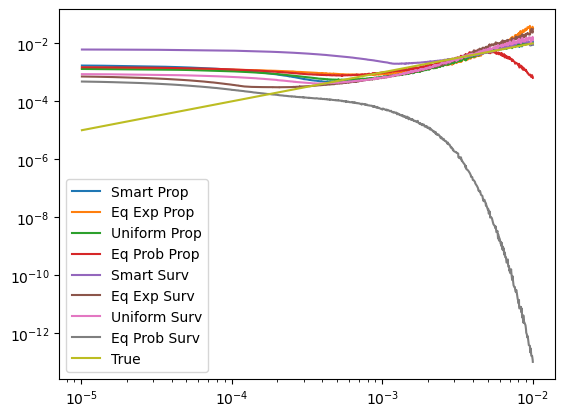

In [ ]:
from matplotlib import pyplot as plt

# Print the data features - mean e, mean p, mean t_tilde, mean b, mean n_samples_random, etc.
print("Mean p_test:", p_test.mean())
print("Mean e_uniform_test:", e_uniform_test.mean())
print("Mean e_smart_test:", e_smart_test.mean())
print("Mean e_eq_exp_test:", e_eq_exp_test.mean())
print("Mean e_eq_prob_test:", e_eq_prob_test.mean())
print("Mean t_tilde_uniform_test:", t_tilde_uniform_test.mean())
print("Mean t_tilde_smart_test:", t_tilde_smart_test.mean())
print("Mean t_tilde_eq_exp_test:", t_tilde_eq_exp_test.mean())
print("Mean t_tilde_eq_prob_test:", t_tilde_eq_prob_test.mean())
print("Mean b_uniform_test:", b_uniform_test.mean())
print("Mean b_smart_test:", b_smart_test.mean())
print("Mean b_eq_exp_test:", b_eq_exp_test.mean())
print("Mean b_eq_prob_test:", b_eq_prob_test.mean())

# Print the mean predicted values
print("Mean uniform_prop_pred:", uniform_prop_pred.mean())
print("Mean smart_prop_pred:", smart_prop_pred.mean())
print("Mean eq_exp_prop_pred:", eq_exp_prop_pred.mean())
print("Mean eq_prob_prop_pred:", eq_prob_prop_pred.mean())
print("Mean uniform_surv_pred:", uniform_surv_pred.mean())
print("Mean smart_surv_pred:", smart_surv_pred.mean())
print("Mean eq_exp_surv_pred:", eq_exp_surv_pred.mean())
print("Mean eq_prob_surv_pred:", eq_prob_surv_pred.mean())

# Plot the results
plt.figure()
plt.yscale("log")
plt.xscale("log")
plt.plot(p_test, smart_prop_pred, label="Smart Prop")
plt.plot(p_test, eq_exp_prop_pred, label="Eq Exp Prop")
plt.plot(p_test, uniform_prop_pred, label="Uniform Prop")
plt.plot(p_test, eq_prob_prop_pred, label="Eq Prob Prop")
plt.plot(p_test, smart_surv_pred, label="Smart Surv")
plt.plot(p_test, eq_exp_surv_pred, label="Eq Exp Surv")
plt.plot(p_test, uniform_surv_pred, label="Uniform Surv")
plt.plot(p_test, eq_prob_surv_pred, label="Eq Prob Surv")
plt.plot(p_test, p_test, label="True")
plt.legend()
plt.show()